In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split

In [2]:
df= pd.read_csv('/home/devil/DL/CDC_Project/train(1)(train(1)).csv')
df.info()
df['age'] = 2015 - df['yr_built']
df['is_renovated'] = (df['yr_renovated'] > 0).astype(int)
df['basement_present'] = (df['sqft_basement'] > 0).astype(int)
df['living_lot_ratio'] = df['sqft_living'] / df['sqft_lot']
df['years_since_renovation'] = np.where(
    df['yr_renovated'] > 0,
    2015 - df['yr_renovated'],
    0
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

/tmp/ipykernel_129525/3374174183.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


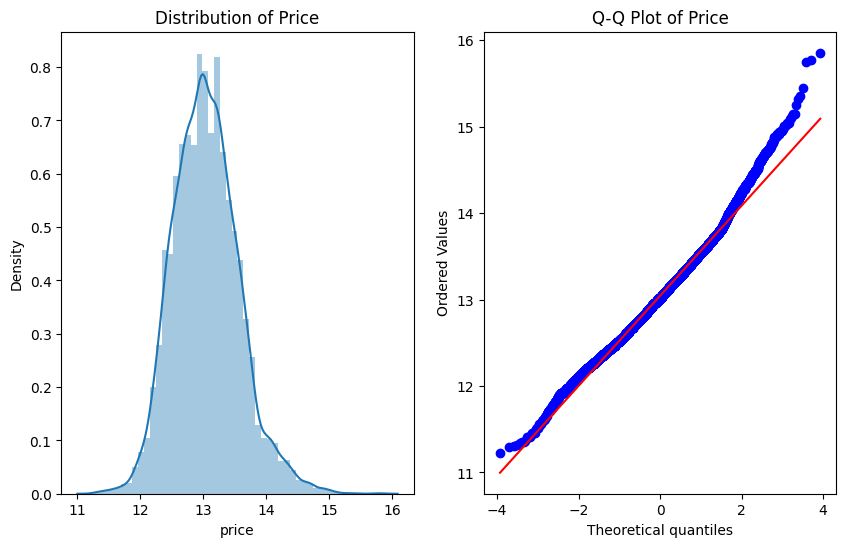

In [3]:
ttf = FunctionTransformer(func=np.log1p)
df['price']= ttf.fit_transform(df[['price']]) 
plt.figure(figsize=(10, 6))
plt.subplot(121)
sns.distplot(df['price'])
plt.title('Distribution of Price')

plt.subplot(122)
stats.probplot(df['price'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Price')
plt.show()

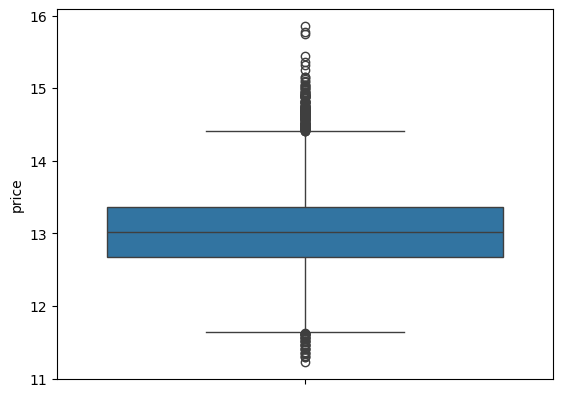

In [4]:
df['price'].describe()
sns.boxplot(df['price'])
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower) & (df['price'] <= upper)]

<Axes: ylabel='price'>

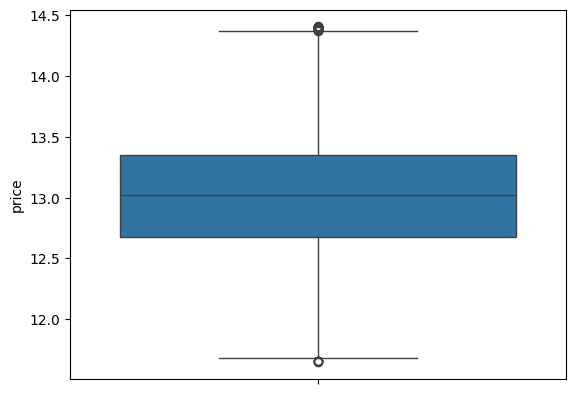

In [5]:
sns.boxplot(df['price'])

In [6]:
X = df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','lat','long','view','condition','grade','sqft_basement','basement_present','age','is_renovated','living_lot_ratio','years_since_renovation','sqft_living15','sqft_lot15']]
y = df[['price']]


Dropped due to correlation: []
sqft_basement  basement_present          0.830667
is_renovated   years_since_renovation    0.770654
sqft_living    sqft_living15             0.751228
               grade                     0.742138
bathrooms      sqft_living               0.735390
sqft_lot       sqft_lot15                0.717530
dtype: float64


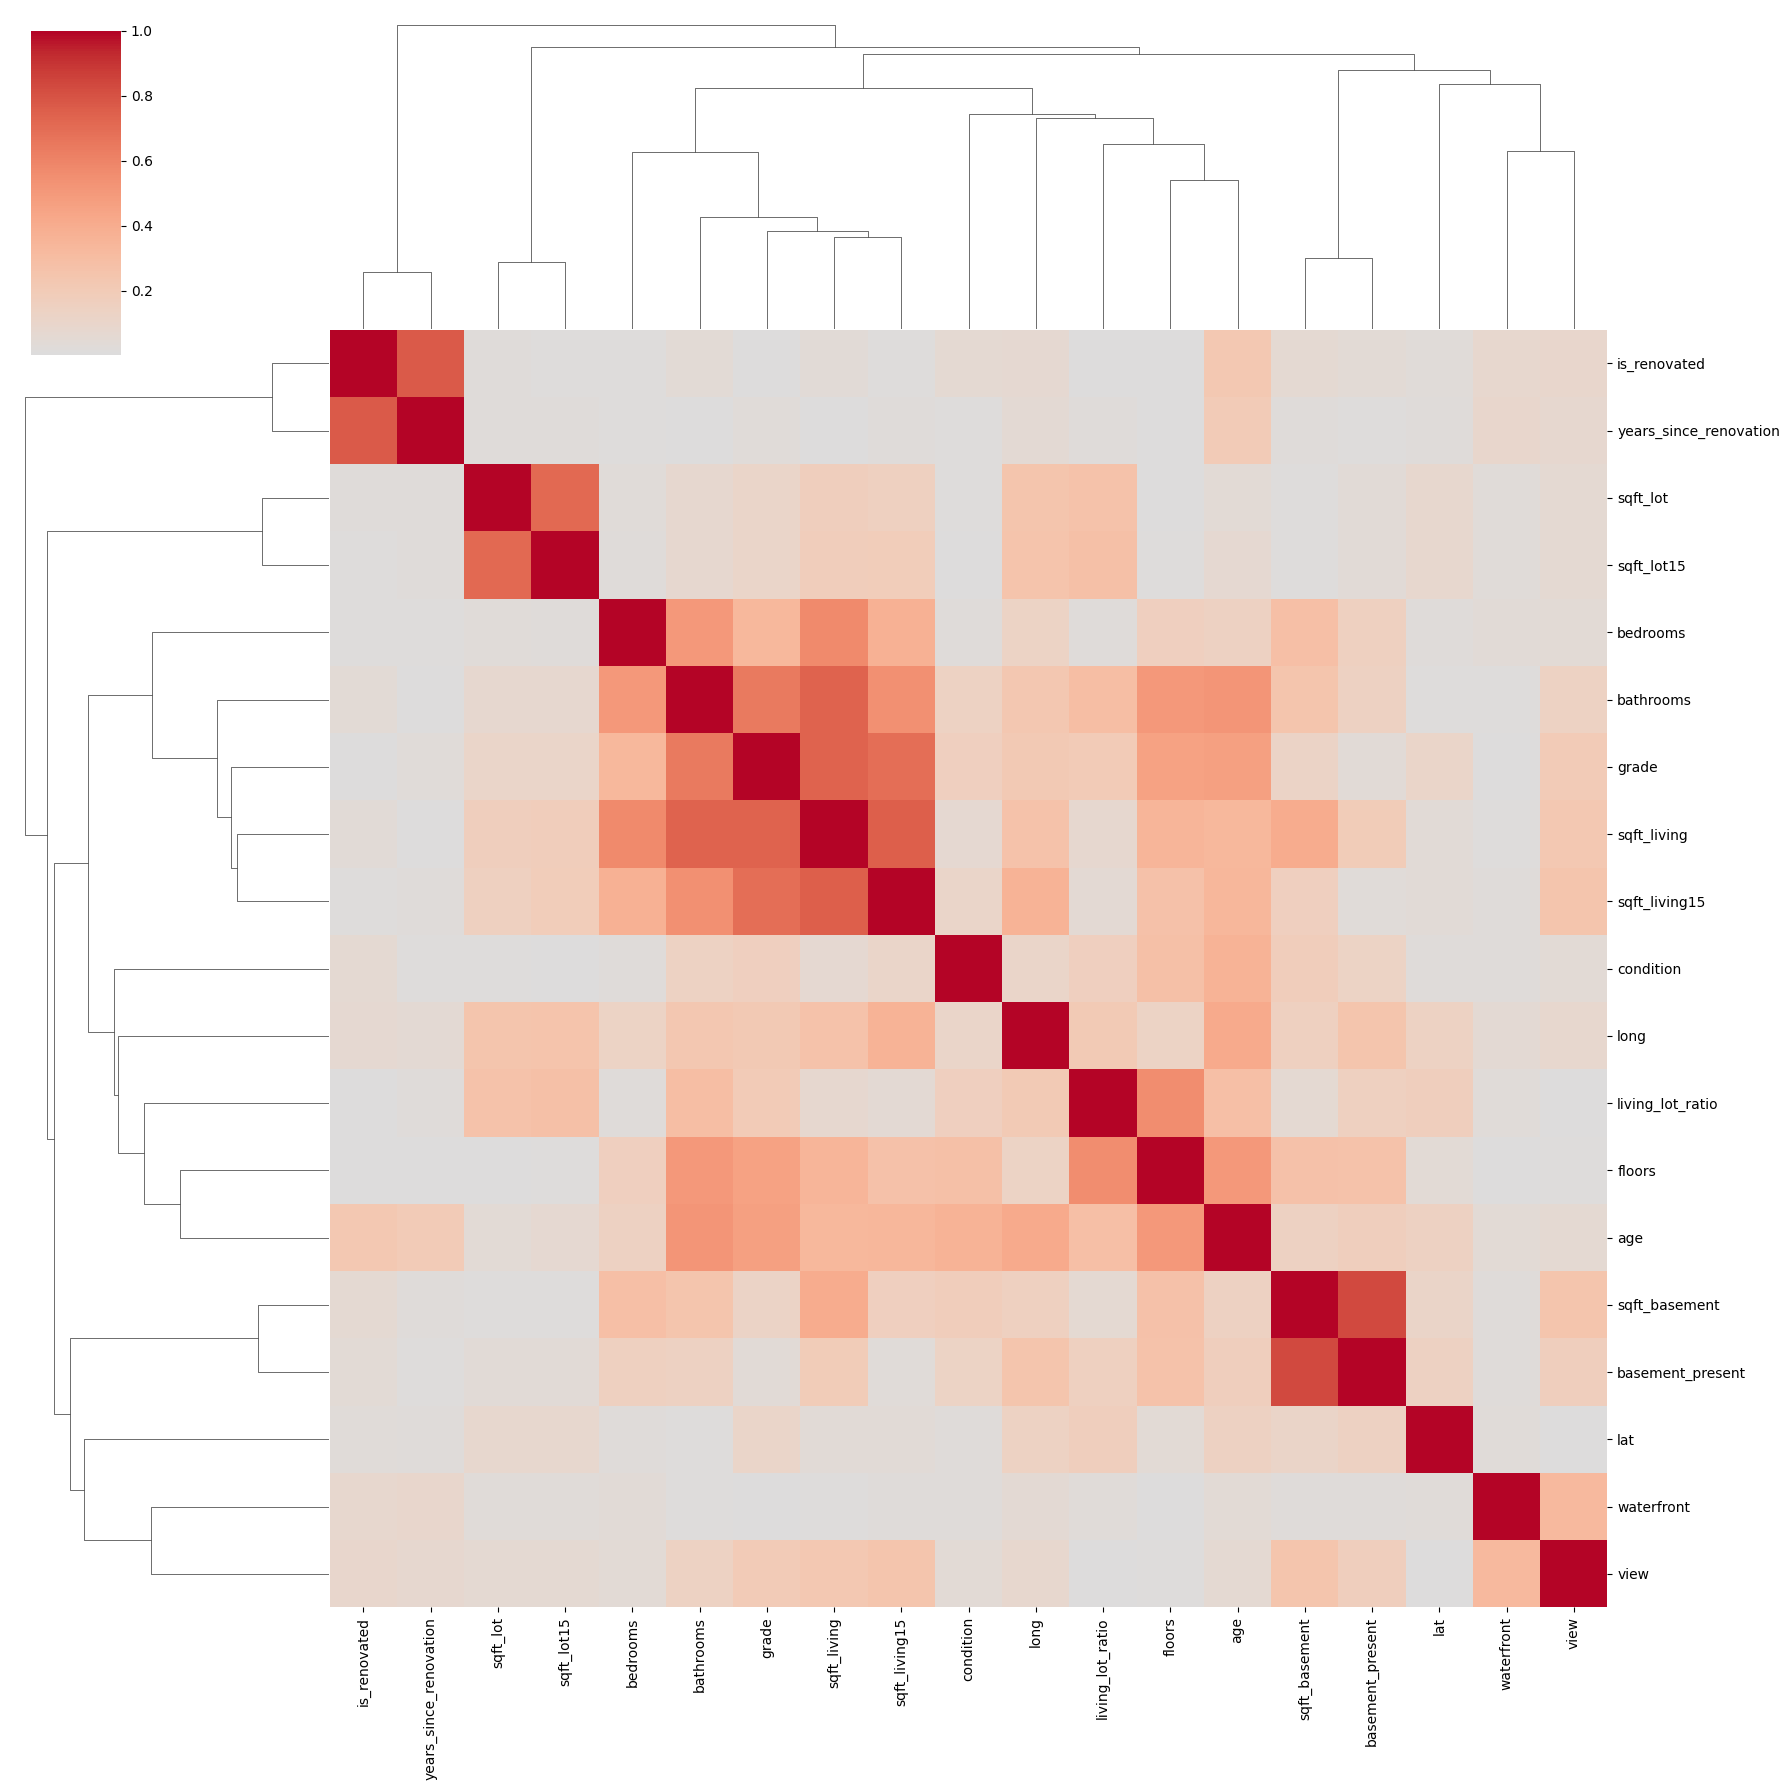

In [7]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
X = X.drop(columns=to_drop)
print("Dropped due to correlation:", to_drop)
threshold = 0.7

high_corr = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)

high_corr = high_corr[high_corr > threshold]
print(high_corr)
sns.clustermap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    figsize=(18, 18)
)
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42) 

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Covariance Matrix:
 [[8.26703500e+18 1.42754992e+06 2.13115381e+07]
 [1.42754992e+06 2.37262381e-01 1.41773356e-01]
 [2.13115381e+07 1.41773356e-01 8.55452024e-01]]
Eigen Values:
 [8.26703500e+18 8.86360998e-01 2.06298221e-01]
Eigen Vectors:
 [[-1.00000000e+00  2.55536950e-12 -3.81367743e-13]
 [-1.72679796e-13 -2.13379857e-01 -9.76969312e-01]
 [-2.57789378e-12 -9.76969312e-01  2.13379857e-01]]
[0.227462   0.36256379 0.47902431 0.57492015 0.6409804  0.70223567
 0.75478566 0.801202   0.83846388 0.87444843 0.90210831 0.92093496
 0.93615037 0.95086133 0.96374615 0.97516718 0.98538891 0.99490689
 1.        ]


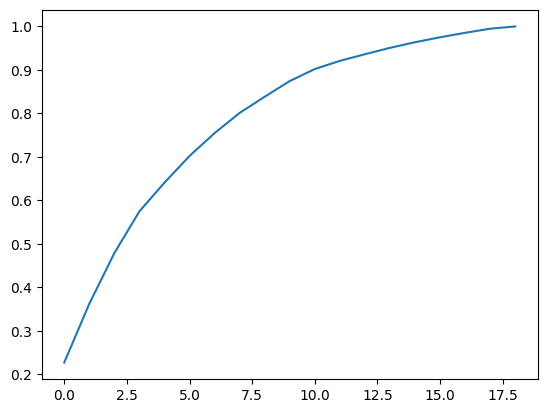

In [10]:
pca = PCA(n_components=None)
X_train_trf = pca.fit_transform(X_train_scaled)
X_test_trf = pca.transform(X_test_scaled)


numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 3:
    cov_input = numeric_df.iloc[:, :3].apply(pd.to_numeric, errors='coerce').dropna()
    covariance_matrix = np.cov(cov_input.T)
else:
    covariance_matrix = np.cov(X_train_scaled.T)

print('Covariance Matrix:\n', covariance_matrix)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
print('Eigen Values:\n', eigen_values)
print('Eigen Vectors:\n', eigen_vectors)

dt = np.cumsum(pca.explained_variance_ratio_)
print(dt)
plt.plot(dt)
plt.show()

In [11]:
# pca = PCA(n_components=10)
# X_train_scaled = pca.fit_transform(X_train_scaled)
# X_test_scaled = pca.transform(X_test_scaled)